In [44]:
import numpy as np
import scipy as sp
import scipy.sparse.linalg as sparse
import matplotlib.pyplot as plt
from hamiltonian import adjacency_hypercube_lattice, construct_ising_hamiltonian
import pandas as pd

import os
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [51]:
# Create the adjacency matrix and the Ising Hamiltonian

L = 20 # length of lattice (Number of Lattice Sites)
adjacency_matrix = adjacency_hypercube_lattice(L, 1)
J = 0.8 # Hamiltonian paramater 1
h = 0.5 # Hamiltonian parameter 2
H = construct_ising_hamiltonian(J, h, adjacency_matrix)

Text(0, 0.5, 'Eigenvalue')

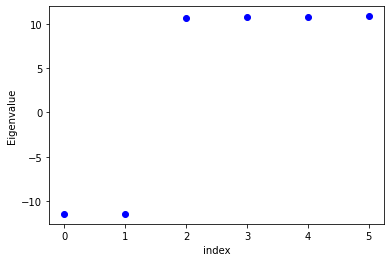

In [6]:
# Calculate theoretical eigenvalues for referernce

ew = sparse.eigsh(H)
plt.plot(ew[0], 'bo')
plt.xlabel('index')
plt.ylabel('Eigenvalue')

In [7]:
def time_correlation(lattice_size, step_size, num_steps, psi0, site_operator, hamiltonian):
    """
    Function to calculate time-correlations

    :param lattice_size: i
    :param step_size:
    :param num_steps:
    :param psi0:
    :param site_operator:
    :param hamiltonian:
    :return: correlations
    """

    # State vectors
    psi = psi0 / np.linalg.norm(psi0)

    # Data Structures to store correlation values
    correlation_data = np.zeros((num_steps, lattice_size))
    j = lattice_size / 2 if lattice_size % 2 ==0 else (lattice_size-1) / 2
    sigma_j = sp.sparse.kron(sp.sparse.eye(2**j), sp.sparse.kron(site_operator, sp.sparse.eye(2**(lattice_size-j-1))))
    intermediate_state = sigma_j @ psi

    print('Time Evolution - Started')
    for step in range(num_steps):
        for i in range(lattice_size):
            sigma_i = sp.sparse.kron(sp.sparse.eye(2**i), sp.sparse.kron(site_operator, sp.sparse.eye(2**(lattice_size-i-1))))
            correlation_data[step, i] = np.vdot(psi, sigma_i @ intermediate_state)

        # Time Evolve the quantum state
        psi = sparse.expm_multiply(-1j * hamiltonian * step_size, psi)
        intermediate_state = sparse.expm_multiply(-1j * hamiltonian * step_size, intermediate_state)
    print('Time Evolution - Finished')

    return correlation_data

def calculate_LR_velocity_slope(correlations, stepsize, num_steps, lattice_size, h, J, site_operator):
    """
    Function to estimate L-R Velocity from thresholded image
    :param correlations:
    :param stepsize:
    :param h:
    :param J:
    :param site_operator:
    :return v: 
    """
    plt.figure()
    plt.imshow(correlations, aspect="auto")
    plt.xlabel('Lattice Site')
    plt.ylabel('Time')
    plt.title(f"Light Cone for dt={stepsize}, h={h}, J={J}, Operator={site_operator}")
    plt.show()

    thresholded_image = correlations >= 0.03
    plt.figure()
    plt.imshow(thresholded_image, aspect="auto")
    plt.xlabel('Lattice Site')
    plt.ylabel('Time')
    plt.title(f"Thresholded Light Cone for dt={stepsize}, h={h}, J={J}, Operator={site_operator}")
    plt.show()

    # Estimate the timestep where the correlation becomes non-zero at the extreme sites
    
    for i in range(num_steps):
        first_site = thresholded_image[i, 0]
        last_site = thresholded_image[i, lattice_size-1]
        if (first_site or last_site) == True:
            distance = lattice_size // 2
            v = distance / (num_steps * stepsize)
            break
        else:
            distance = np.max(np.where(thresholded_image[i,:]==True)) - lattice_size // 2
            v = distance / (num_steps * stepsize)
            break   

    return v


In [52]:
dt = 0.007 # time-step size
N = 1000 # number of time steps
psi0 = np.random.randn(2**L) + 1j * np.random.randn(2**L)
psi0 /= np.linalg.norm(psi0) # initial state
Pauli_Z = np.array([[1, 0],[0, -1]])
Pauli_Y = np.array([[0, -1j],[1j, 0]])
Pauli_X = np.array([[0, 1],[1, 0]]) # Pauli Z matrix as the site operators

correlations = time_correlation(L, dt, N, psi0, Pauli_X, H)

J = 0.8
h = 0.5
V = []
J_h = []

H = construct_ising_hamiltonian(i, j, adjacency_matrix)
correlations = time_correlation(L, dt, N, psi0, Pauli_X, H)
plt.imshow(correlations, aspect="auto")
thresholded_image = correlations >= 0.03
plt.figure()
plt.show()

location = np.max(np.where(thresholded_image[-1,:]==True))
v = (location / (N*dt))
print("J : ", i, " h : ", j, ", LR Velocity : ", v)
V.append(v)
J_h.append(i)



Time Evolution - Started


/home/rahul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


KeyboardInterrupt: 

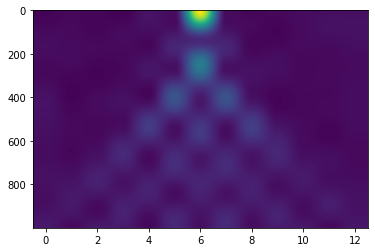

In [78]:
plt.imshow(correlations, aspect="auto")
plt.show()
v_ising = 2 * 1.5 * np.sqrt(J * h) # from L-R estimation paper

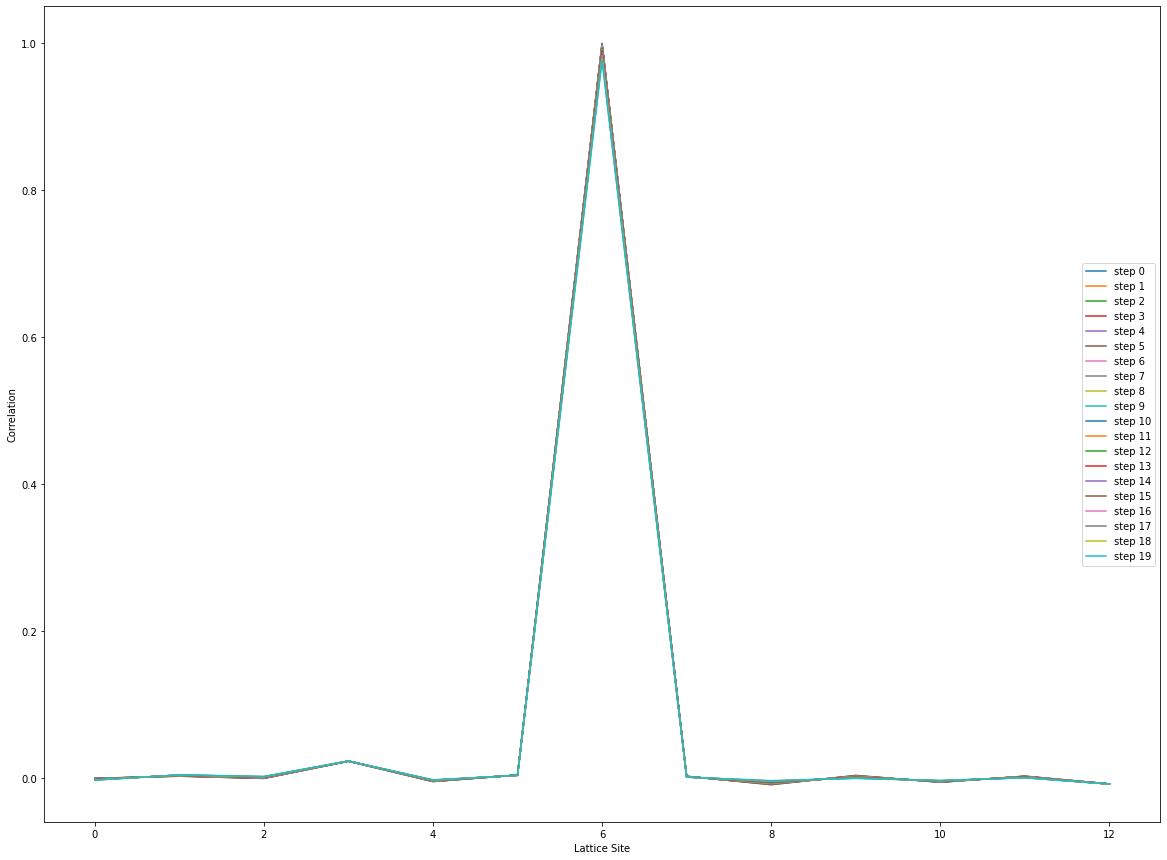

In [85]:
# Visualizing the evolution of correlations in different timesteps for all lattice sites

plt.figure(figsize=(20,15))
for i in range(N // 50):
    plt.plot(correlations[i,:], label=f'step {i}')
plt.xlabel("Lattice Site")
plt.ylabel("Correlation")
plt.legend(loc='right')
plt.show()

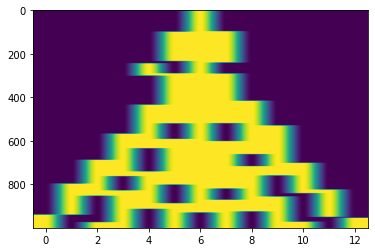

[ True False  True  True False  True False  True False  True  True False
  True]
Location : 13
Iterations : 1000
1.7142857142857142


In [79]:
# Thresholding the correlation data and calculating velocity from slope

thresholded_image = correlations >= 0.03
plt.imshow(thresholded_image, aspect="auto")
plt.show()
print(thresholded_image[999,:])

location = np.max(np.where(thresholded_image[-1,:]==True))
print("Location :", location+1)
print("Iterations :", N)
v = (location / (N*dt))
print(v)


Running with Stepsize :  0.001
Time Evolution - Started


/home/rahul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


Time Evolution - Finished


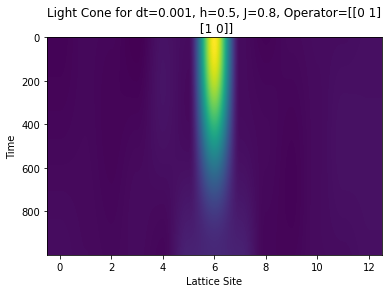

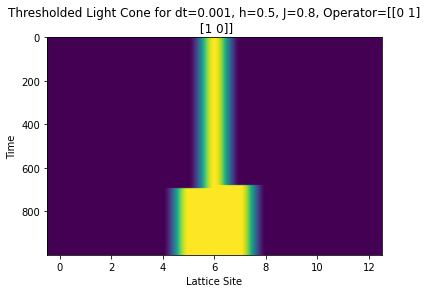

Time Elapsed :  27.05821180343628 s

Running with Stepsize :  0.002
Time Evolution - Started
Time Evolution - Finished


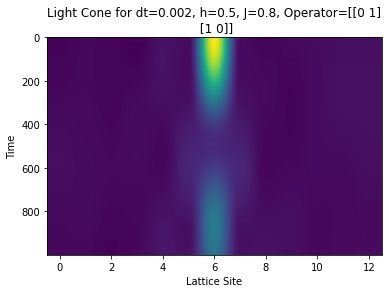

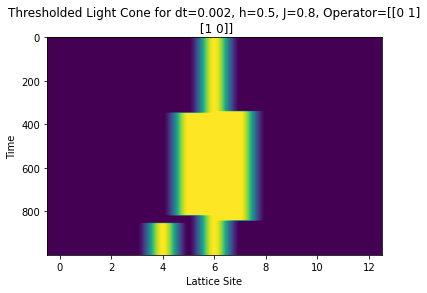

Time Elapsed :  28.345946550369263 s

Running with Stepsize :  0.005
Time Evolution - Started
Time Evolution - Finished


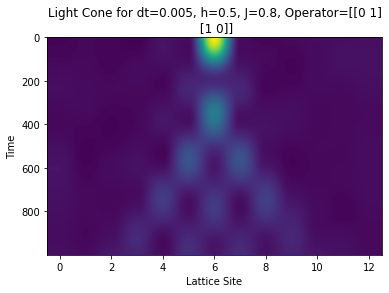

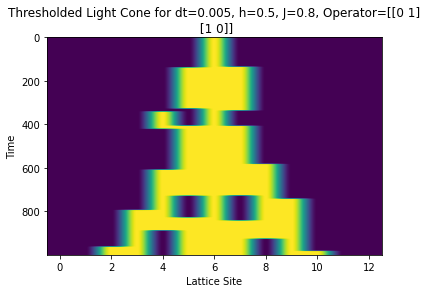

Time Elapsed :  28.407937049865723 s

Running with Stepsize :  0.007
Time Evolution - Started
Time Evolution - Finished


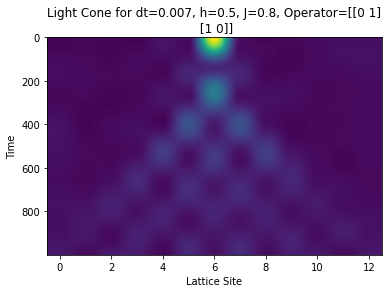

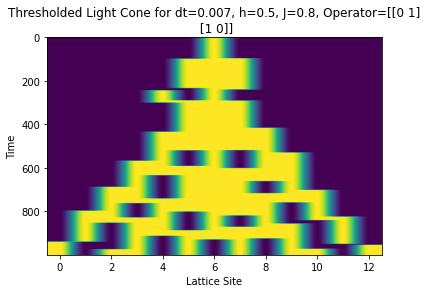

Time Elapsed :  29.44851303100586 s

Running with Stepsize :  0.01
Time Evolution - Started
Time Evolution - Finished


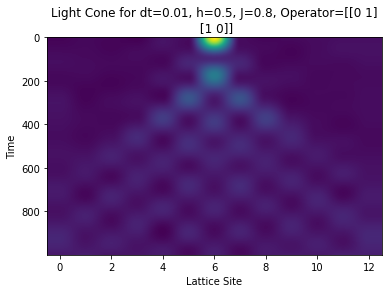

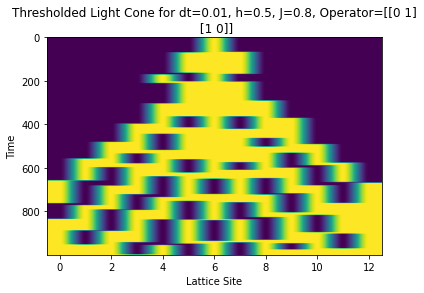

Time Elapsed :  30.149601936340332 s

Running with Stepsize :  0.02
Time Evolution - Started
Time Evolution - Finished


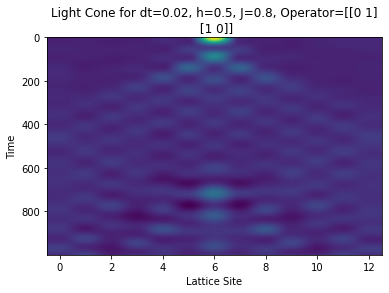

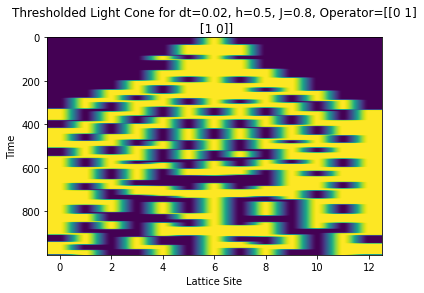

Time Elapsed :  32.013145446777344 s

Running with Stepsize :  0.05
Time Evolution - Started
Time Evolution - Finished


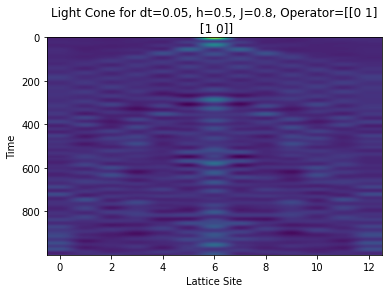

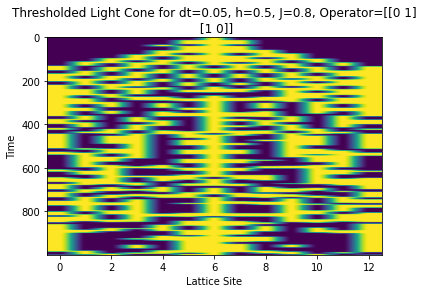

Time Elapsed :  34.748539209365845 s

Running with Stepsize :  0.07
Time Evolution - Started
Time Evolution - Finished


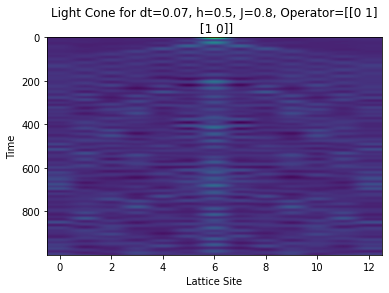

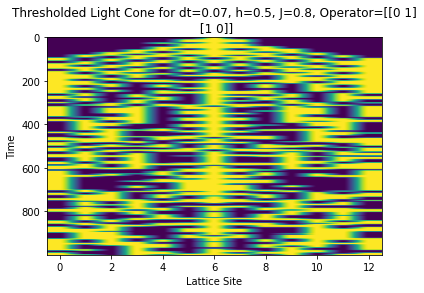

Time Elapsed :  37.47325849533081 s


In [89]:
# Generate some data between differernt step-sizes and velocities

stepsizes = [0.001, 0.002, 0.005, 0.007, 0.01, 0.02, 0.05, 0.07]
site_operator = Pauli_X
dt = []
vel_slope = []

for stepsize in stepsizes:
    start_time = time.time()
    velocities = []
    data = pd.DataFrame(columns=['dt', 'LR_Velocity_Slope'])
    print("\nRunning with Stepsize : ", stepsize)
    correlation_data = time_correlation(lattice_size=L, step_size=stepsize, num_steps=N, psi0=psi0, site_operator=site_operator, hamiltonian=H)
    v_slope = calculate_LR_velocity_slope(correlation_data, stepsize, N, L, h, J, Pauli_X)

    vel_slope.append(v_slope)
    dt.append(stepsize)
    data['dt'] = dt
    data['LR_Velocity_Slope'] = vel_slope
    data.head()

    if os.path.exists('data.csv'):
        os.remove('data.csv')  
        data.reset_index(drop=True, inplace=True)      
        data.to_csv('data.csv')
    else:
        data.reset_index(drop=True, inplace=True)
        data.to_csv('data.csv')

    end_time = time.time()
    print("Time Elapsed : ", end_time-start_time, "s")

<Figure size 432x288 with 0 Axes>

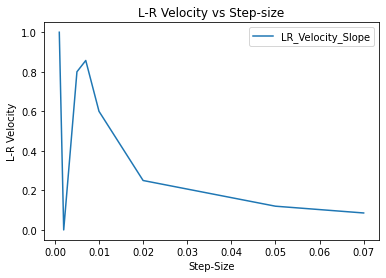

In [92]:
# Plot of L-R Velocity against stepsize

plt.figure()
data.plot(x='dt', y='LR_Velocity_Slope')
plt.xlabel("Step-Size")
plt.ylabel("L-R Velocity")
plt.title("L-R Velocity vs Step-size")
plt.show()

/home/rahul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


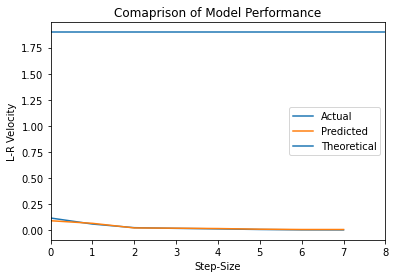

In [100]:
# Fitting a Random Forest model from the available data

model = RandomForestRegressor(max_depth=2, random_state=0)
X = data['J'].to_numpy().reshape(-1,1)
y = data['LR_Velocity'].to_numpy().reshape(-1,1)
model.fit(X, y)
pred = model.predict(X)
plt.plot(y, label='Actual')
plt.plot(pred, label='Predicted')
plt.axhline(v_ising, label='Theoretical')
plt.xlabel("Step-Size")
plt.ylabel("L-R Velocity")
plt.title("Comaprison of Model Performance")
plt.xlim([0, len(stepsizes)])
plt.legend()
plt.show()

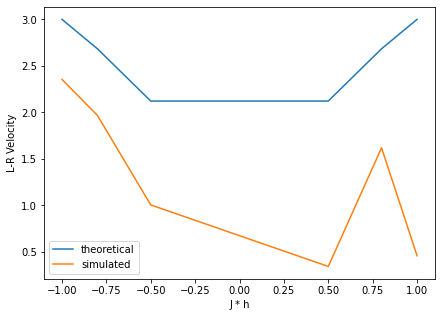

In [43]:
plt.figure(figsize=(7,5))
plt.plot(J, theoretical, label='theoretical')
plt.plot(J, simulated, label='simulated')
plt.xlabel('J * h')
plt.ylabel('L-R Velocity')
plt.title('Change of L-R Velocity with Hamiltonian parameters')
plt.legend()

In [50]:
regressor  = LinearRegression()
regressor.fit(np.array(J).reshape(-1,1), (np.array(simulated).reshape(-1,1)))

LinearRegression()